<a href="https://colab.research.google.com/github/ArseniyKoz/uni.neuralnetworks/blob/main/nn_practice_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import torch
import numpy as np

In [56]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')
  PYTORCH_CUDA_ALLOC_CONF=expandable_segments =True

CUDA is available! Training on GPU ...


In [57]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision.models import resnet50
from torchvision.models import resnet18
from torchvision.models.efficientnet import EfficientNet
from torchvision.models import efficientnet_b7
from torchvision import models

In [58]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 150
# percentage of training set to use as validation
valid_size = 0.2

аугментация

In [59]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    #transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transformer = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [60]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=train_transformer)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=test_transformer)

Files already downloaded and verified
Files already downloaded and verified


Семплирование

In [61]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [62]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
  sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
  sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
  num_workers=num_workers)

In [63]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
'dog', 'frog', 'horse', 'ship', 'truck']

Визуализация данных (одного батча)

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

In [65]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

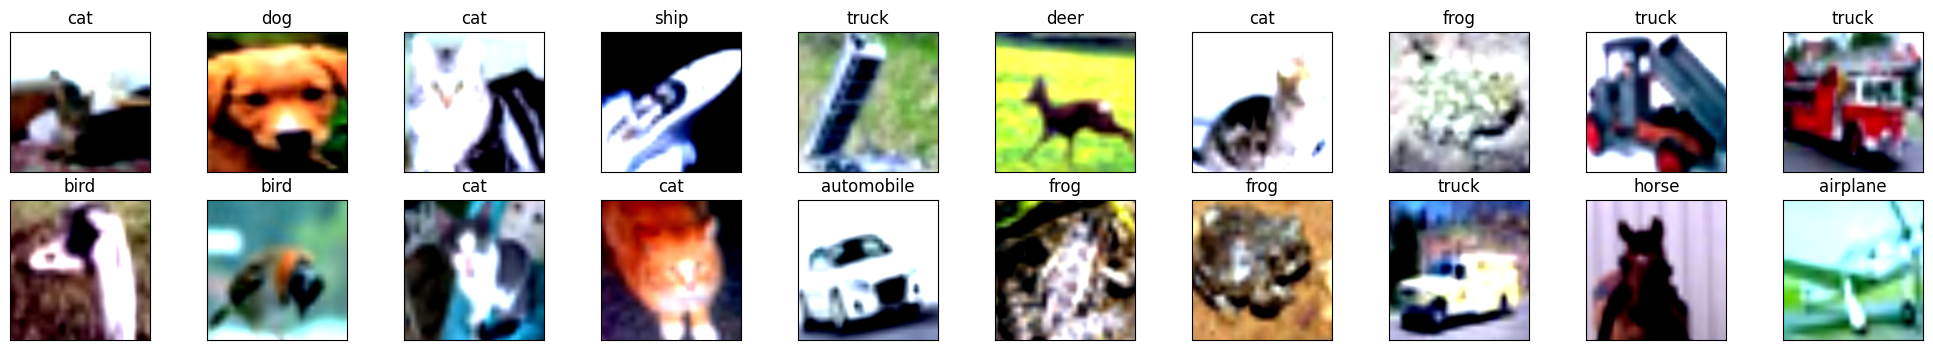

In [66]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

Архитектура сети

In [67]:
import torch.nn as nn
import torch.nn.functional as F

In [68]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 =  nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(256*4*4, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 10)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)

        out = self.conv1(out)
        out = self.act(out)

        out = self.maxpool(out)

        out = self.dropout(out)

        out = self.conv2(out)
        out = self.act(out)

        out = self.conv3(out)
        out = self.act(out)

        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)

        out = self.dropout(out)

        out = self.conv5(out)
        out = self.act(out)

        out = self.maxpool(out)

        out = self.flat(out)

        out = self.dropout(out)

        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        out = self.act(out)
        out = self.linear3(out)
        return out

In [69]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.model = resnet50(weights="DEFAULT")
        self.in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [70]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [71]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

In [72]:
block_type = 'bottleneck'

In [73]:
class ResBlock(nn.Module):
    def __init__(self, num_nc):
      super().__init__()

      self.conv0 = nn.Conv2d(num_nc, num_nc, kernel_size=3, padding=1)
      self.norm0 = nn.BatchNorm2d(num_nc)
      self.act = nn.ReLU(inplace=True)
      self.conv1 = nn.Conv2d(num_nc, num_nc,kernel_size=3, padding=1)
      self.norm1 = nn.BatchNorm2d(num_nc)

    def forward(self, x):
      out = self.conv0(x)
      out = self.norm0(out)
      out = self.act(out)
      out = self.conv1(x)
      out = self.norm1(out)

      return self.act(x + out)

In [74]:
class BottleneckBlock(nn.Module):
    def __init__(self, num_nc):
      super().__init__()

      self.act = nn.LeakyReLU(0.2, inplace=True)

      self.conv0 = nn.Conv2d(num_nc, num_nc//4, kernel_size=1, padding=0)
      self.norm0 = nn.BatchNorm2d(num_nc//4)
      self.conv1 = nn.Conv2d(num_nc//4, num_nc//4, kernel_size=3, padding=1)
      self.norm1 = nn.BatchNorm2d(num_nc//4)
      self.conv2 = nn.Conv2d(num_nc//4, num_nc, kernel_size=1, padding=0)
      self.norm3 = nn.BatchNorm2d(num_nc)

    def forward(self, x):
      out = self.conv0(x)
      out = self.norm0(out)
      out = self.conv1(out)
      out = self.norm1(out)
      out = self.conv2(out)
      out = self.norm3(out)

      return self.act(x + out)

In [75]:
class ResTruck(nn.Module):
    def __init__(self, num_nc, num_blocks, block_type: 'classic'):
      super().__init__()
      truck = []
      for i in range(num_blocks):
        if block_type == 'classic':
          truck += [ResBlock(num_nc)]
        elif block_type == 'bottleneck':
          truck += [BottleneckBlock(num_nc)]
      self.truck = nn.Sequential(*truck)
    def forward(self, x):
      return self.truck(x)

In [76]:
class MyResNet(nn.Module):
    def __init__(self, in_nc, num_nc, out_nc):
      super().__init__()

      self.flat = nn.Flatten()

      self.conv0 = nn.Conv2d(in_nc, num_nc, kernel_size = 7, stride = 2)
      #self.norm
      self.act = nn.LeakyReLU(0.2, inplace=True)
      self.maxpool = nn.MaxPool2d(2, 2)

      self.layer1 = ResTruck(num_nc, 3, block_type=block_type)
      self.conv1 = nn.Conv2d(num_nc, 2*num_nc, 3, stride = 2, padding = 1)

      self.layer2 = ResTruck(2*num_nc, 4, block_type=block_type)
      self.conv2 = nn.Conv2d(2*num_nc, 4*num_nc, 3, stride = 2, padding = 1)

      self.layer3 = ResTruck(4*num_nc, 6, block_type=block_type)
      self.conv3 = nn.Conv2d(4*num_nc, 4*num_nc, 3, stride = 2, padding = 1)

      self.layer4 = ResTruck(4*num_nc, 3, block_type=block_type)

      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.linear = nn.Linear(4*num_nc, out_nc)

    def forward(self, x):
      out = self.conv0(x)
      out = self.act(out)
      out = self.maxpool(out)
      out = self.layer1(out)
      out = self.conv1(out)
      out = self.layer2(out)
      out = self.conv2(out)
      out = self.layer3(out)
      out = self.conv3(out)
      out = self.layer4(out)

      out = self.avgpool(out)
      out = self.flat(out)
      out = self.linear(out)

      return out

In [77]:
#model = ResNet50(num_classes=10)
model = ResNet18(num_classes=10)
#model = ConvNet()
#model = EfficientNetModel(num_classes=10)
#model = VGG16(out_nc=10)
#model = MyResNet(3, 64, 10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [78]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Функция потерь и оптимизатор

In [79]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.parameters())
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.00005)


Обучение сети





In [80]:
def train_model(model, optimizer, train_loader, valid_loader, criterion, device, num_epochs=100):
  valid_loss_min = np.Inf # track change in validation loss
  for epoch in range(1, num_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
      # move tensors to device
      data, target = data.to(device), target.to(device)
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # update training loss
      train_loss += loss.item()*data.size(0)
    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
      if train_on_gpu:
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'best_model_cifar.pth')
      valid_loss_min = valid_loss

In [81]:
train_model(model, optimizer, train_loader, valid_loader, criterion, device, num_epochs=15)

Epoch: 1 	Training Loss: 0.432560 	Validation Loss: 0.119277
Validation loss decreased (inf --> 0.119277). Saving model ...
Epoch: 2 	Training Loss: 0.266414 	Validation Loss: 0.086428
Validation loss decreased (0.119277 --> 0.086428). Saving model ...


KeyboardInterrupt: 

Тестирование модели

In [82]:
model.load_state_dict(torch.load('best_model_cifar.pth'))

<ipython-input-82-3357782fe2b1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_cifar.pth'))


<All keys matched successfully>

In [83]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
# iterate over test data
for data, target in test_loader:

  # move tensors to GPU if CUDA is available
  data, target = data.to(device), target.to(device)
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batch_size):
    if i == len (target.data):
      break
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
    classes[i], 100 * class_correct[i] / class_total[i],
    np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))# obtain one batch of test images

Test Loss: 0.408024

Test Accuracy of airplane: 76% (768/1000)
Test Accuracy of automobile: 88% (889/1000)
Test Accuracy of  bird: 83% (836/1000)
Test Accuracy of   cat: 77% (771/1000)
Test Accuracy of  deer: 87% (878/1000)
Test Accuracy of   dog: 86% (867/1000)
Test Accuracy of  frog: 86% (865/1000)
Test Accuracy of horse: 84% (840/1000)
Test Accuracy of  ship: 92% (925/1000)
Test Accuracy of truck: 98% (980/1000)

Test Accuracy (Overall): 86% (8619/10000)


batches: 50
=====================

ResNet50 + Adam => 87%

ResNet50 + AdamW => 87%

ResNet50 + SGD => 78%

ResNet50 + SGD decay => 83%

ConvNet + Adam => 80%

ResNet50 + Adam decay => 78%


MyResNet + Adam => 73%


ResNet18 + resize + crop + Adam => 92%


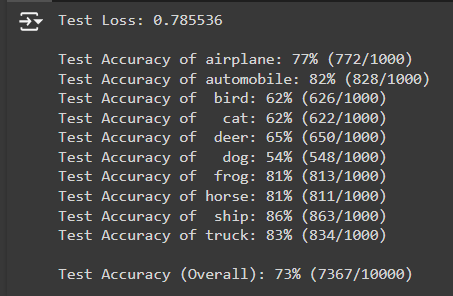


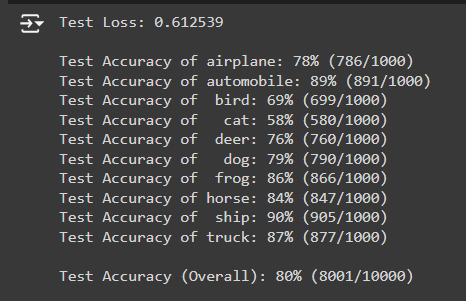

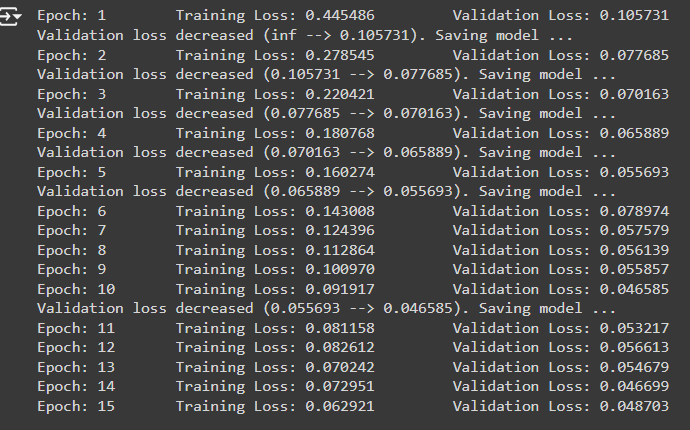


Визуализация некоторых результатов

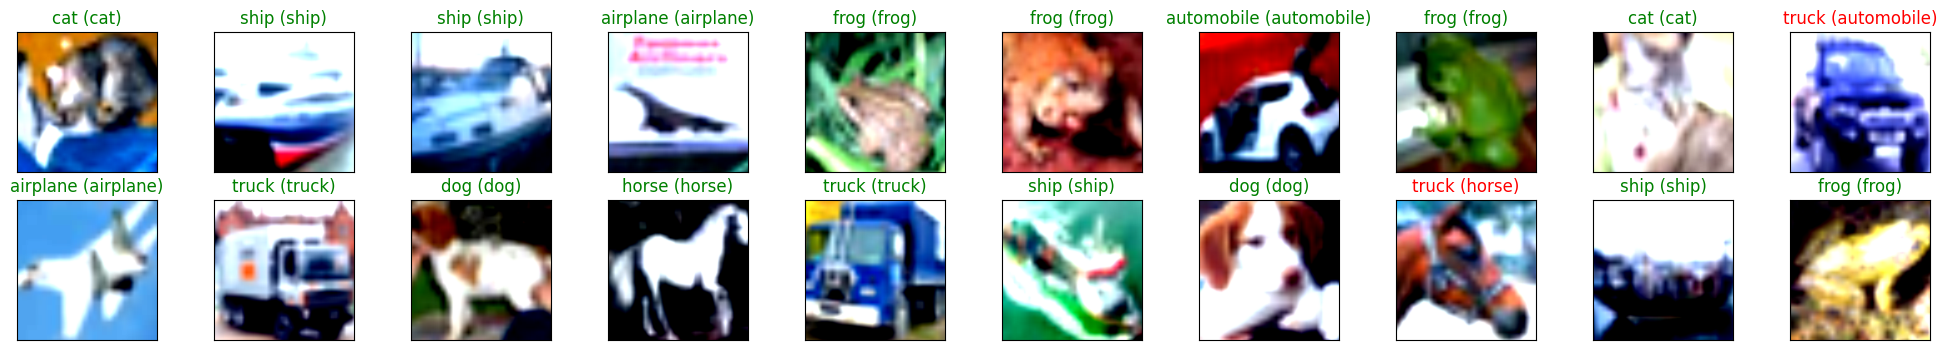

In [84]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()
# move model inputs to cuda, if GPU available
images = images.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx].cpu())

  ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))